In [ ]:
!nvidia-smi

Fri Sep  4 08:21:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
# https://github.com/42io/dataset/tree/master/google_speech_commands
DATASET_FILE = '1NgIw6JrdjDcRhnAxbheqtAcV5Fr-wUJu' # 0-9up.npz

In [ ]:
!test -f "$DATASET_FILE" || gdown --id "$DATASET_FILE" -O "$DATASET_FILE"

Downloading...
From: https://drive.google.com/uc?id=1NgIw6JrdjDcRhnAxbheqtAcV5Fr-wUJu
To: /content/1NgIw6JrdjDcRhnAxbheqtAcV5Fr-wUJu
2.59GB [00:27, 94.4MB/s]


In [ ]:
md5 = !md5sum "$DATASET_FILE"
assert '54821a74684e7bbb9b3acd853960d9cd' == md5[0].split()[0]

In [ ]:
dset = np.load(DATASET_FILE)
print(dset['x_train'].shape)

(1095480, 637)


In [ ]:
x_train, x_test, x_valid = (
    dset[i].reshape(-1, 49, 13)[:,1:-1] 
    for i in ['x_train', 'x_test', 'x_valid']
)
y_train = dset['y_train']
y_test  = dset['y_test']
y_valid = dset['y_valid']

In [ ]:
def spectrogram_masking(spectrogram, dim=1, masks_number=2, mask_max_size=5):
  """Spectrogram masking on frequency or time dimension.
  Args:
    spectrogram: Input spectrum [batch, time, frequency]
    dim: dimension on which masking will be applied: 1 - time; 2 - frequency
    masks_number: number of masks
    mask_max_size: mask max size
  Returns:
    masked spectrogram
  """
  if dim not in (1, 2):
    raise ValueError('Wrong dim value: %d' % dim)
  input_shape = spectrogram.shape
  time_size, frequency_size = input_shape[1:3]
  dim_size = input_shape[dim]  # size of dimension on which mask is applied
  stripe_shape = [1, time_size, frequency_size]
  for _ in range(masks_number):
    mask_end = tf.random.uniform([], 0, mask_max_size, tf.int32)
    mask_start = tf.random.uniform([], 0, dim_size - mask_end, tf.int32)

    # initialize stripes with stripe_shape
    stripe_ones_left = list(stripe_shape)
    stripe_zeros_center = list(stripe_shape)
    stripe_ones_right = list(stripe_shape)

    # update stripes dim
    stripe_ones_left[dim] = dim_size - mask_start - mask_end
    stripe_zeros_center[dim] = mask_end
    stripe_ones_right[dim] = mask_start

    # generate mask
    mask = tf.concat((
        tf.ones(stripe_ones_left, spectrogram.dtype),
        tf.zeros(stripe_zeros_center, spectrogram.dtype),
        tf.ones(stripe_ones_right, spectrogram.dtype),
    ), dim)
    spectrogram = spectrogram * mask
  return spectrogram

In [ ]:
plt.rc('figure', figsize=(13, 4))

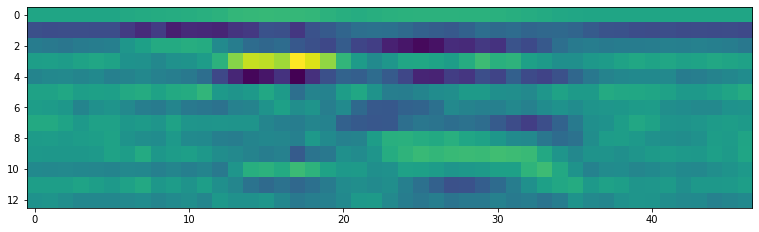

In [ ]:
plt.imshow(x_train[0].T)

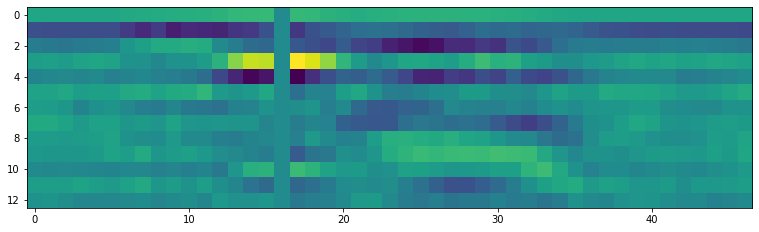

In [ ]:
plt.imshow(spectrogram_masking(x_train[0:1], 1, 3, 3).numpy()[0].T)

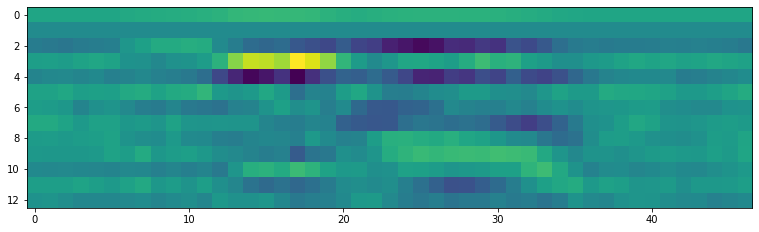

In [ ]:
plt.imshow(spectrogram_masking(x_train[0:1], 2, 2, 2).numpy()[0].T)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(len(x_train))
train_dataset = train_dataset.batch(512)
train_dataset = train_dataset.map(lambda x, y: (spectrogram_masking(x, 1, 3, 3), y))
train_dataset = train_dataset.map(lambda x, y: (spectrogram_masking(x, 2, 2, 2), y))

In [ ]:
x = x_in = keras.Input(shape=(47, 13))

x = keras.layers.SeparableConv1D(32, 4, 2, padding="same")(x)
x = keras.layers.ReLU()(x)

for p in [None, 2, None, 12]:
  x = keras.layers.SeparableConv1D(32, 3, padding="same")(x)
  x = keras.layers.ReLU()(x)
  if p: x = keras.layers.MaxPool1D(p)(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(32)(x)
x = keras.layers.ReLU()(x)

x = keras.layers.Dense(12, activation='softmax')(x)

model = keras.Model(inputs=x_in, outputs=x)

model.summary()

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 47, 13)]          0         
_________________________________________________________________
separable_conv1d (SeparableC (None, 24, 32)            500       
_________________________________________________________________
re_lu (ReLU)                 (None, 24, 32)            0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 24, 32)            1152      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 24, 32)            0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 24, 32)            1152      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 24, 32)           

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=1000,
        restore_best_weights=True)

history = model.fit(train_dataset,
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stopping],
                    verbose=2,
                    epochs=100500)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


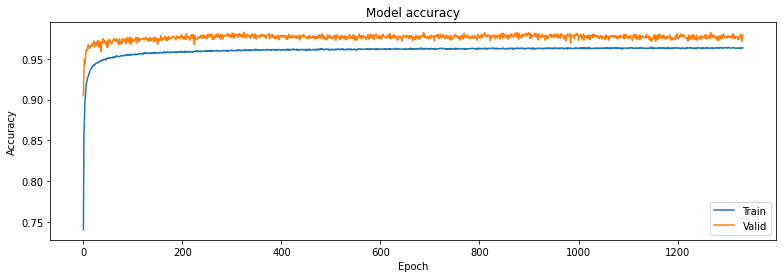

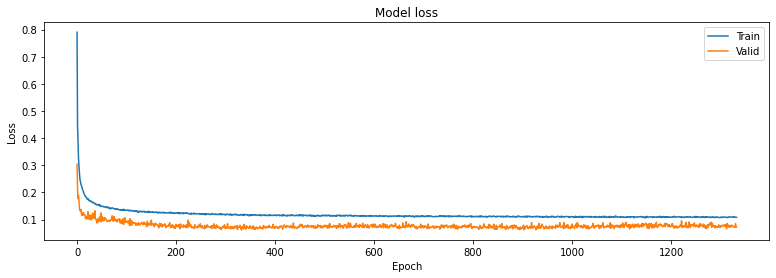

In [ ]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [ ]:
results = model.evaluate(x_train, y_train, verbose=0)
print('train loss, train acc:', results)

results = model.evaluate(x_test, y_test, verbose=0)
print('test loss, test acc:', results)

results = model.evaluate(x_valid, y_valid, verbose=0)
print('valid loss, valid acc:', results)

train loss, train acc: [0.06018223613500595, 0.9801082611083984]
test loss, test acc: [0.09043777734041214, 0.9700503349304199]
valid loss, valid acc: [0.061987847089767456, 0.9795130491256714]


In [ ]:
assert(len(x_test) + len(x_valid) == 7141)
pred = model.predict(x_test).argmax(axis=-1)
print(np.sum(pred != y_test), len(pred))
pred = model.predict(x_valid).argmax(axis=-1)
print(np.sum(pred != y_valid), len(pred))

113 3773
69 3368


In [ ]:
!apt install xxd
!git clone https://github.com/tensorflow/tensorflow.git -b v2.3.0 --depth 1 tf
!make -C tf/ -f tensorflow/lite/micro/tools/make/Makefile generate_projects
!ln -s tf/tensorflow/lite/micro/tools/make/gen/linux_x86_64/prj/hello_world/make/tensorflow
!ln -s tf/tensorflow/lite/micro/tools/make/gen/linux_x86_64/prj/hello_world/make/third_party

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xxd
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 49.4 kB of archives.
After this operation, 200 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xxd amd64 2:8.0.1453-1ubuntu1.3 [49.4 kB]
Fetched 49.4 kB in 0s (116 kB/s)
Selecting previously unselected package xxd.
(Reading database ... 144579 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.3_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.3) ...
Setting up xxd (2:8.0.1453-1ubuntu1.3) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Cloning into 'tf'...
remote: Enumerating objects: 21849, done.
remote: Counting objects: 

In [ ]:
%%file guess.cc
#include <fstream>

#include "tensorflow/lite/micro/all_ops_resolver.h"
#include "tensorflow/lite/micro/micro_error_reporter.h"
#include "tensorflow/lite/micro/micro_interpreter.h"
#include "tensorflow/lite/schema/schema_generated.h"
#include "tensorflow/lite/version.h"

static_assert(sizeof(float) == 4, "WTF");

#define TFLITE_MINIMAL_CHECK(x, ...)                                          \
  if (!(x)) {                                                                 \
    TF_LITE_REPORT_ERROR(error_reporter, __VA_ARGS__);                        \
    TF_LITE_REPORT_ERROR(error_reporter, "Err at %s:%d", __FILE__, __LINE__); \
    exit(1);                                                                  \
  }

//-------------------------------------------------------------------//

namespace {
  tflite::ErrorReporter* error_reporter = nullptr;
  const tflite::Model* model = nullptr;
  tflite::MicroInterpreter* interpreter = nullptr;
  TfLiteTensor* input = nullptr;
  TfLiteTensor* output = nullptr;
  constexpr int kTensorArenaSize = 100 * 1024;
  uint8_t tensor_arena[kTensorArenaSize];
  char *buffer = nullptr;
}

//-------------------------------------------------------------------//

int main(int argc, char* argv[]) {

  tflite::MicroErrorReporter micro_error_reporter;
  error_reporter = &micro_error_reporter;

  TFLITE_MINIMAL_CHECK(argc == 2, "guess <tflite model>");

  // Load model
  std::ifstream ifs(argv[1], std::ifstream::binary);
  if (ifs) {
    ifs.seekg (0, ifs.end);
    int length = ifs.tellg();
    ifs.seekg (0, ifs.beg);

    buffer = new char[length];
    TFLITE_MINIMAL_CHECK(buffer, "can't allocate buffer");

    ifs.read(buffer, length);

    TFLITE_MINIMAL_CHECK(ifs, "only %d could be read", ifs.gcount());

    ifs.close();
  }

  // Map the model into a usable data structure. This doesn't involve any
  // copying or parsing, it's a very lightweight operation.
  model = tflite::GetModel(buffer);
  TFLITE_MINIMAL_CHECK(model->version() == TFLITE_SCHEMA_VERSION, 
                       "Model provided is schema version %d not equal "
                       "to supported version %d.",
                       model->version(), TFLITE_SCHEMA_VERSION);

  // This pulls in all the operation implementations we need.
  // NOLINTNEXTLINE(runtime-global-variables)
  static tflite::AllOpsResolver resolver;

  // Build an interpreter to run the model with.
  tflite::MicroInterpreter static_interpreter(
        model, resolver, tensor_arena, kTensorArenaSize, error_reporter);
  interpreter = &static_interpreter;

  // Allocate memory from the tensor_arena for the model's tensors.
  TfLiteStatus status = interpreter->AllocateTensors();
  TFLITE_MINIMAL_CHECK(status == kTfLiteOk, "AllocateTensors() failed");

  TFLITE_MINIMAL_CHECK(interpreter->outputs().size() == 1, "WTF");
  TFLITE_MINIMAL_CHECK(interpreter->inputs().size() == 1, "WTF");

  // Obtain pointers to the model's input and output tensors.
  input = interpreter->input(0);
  output = interpreter->output(0);

  TFLITE_MINIMAL_CHECK(input->type == kTfLiteFloat32, "WTF");
  TFLITE_MINIMAL_CHECK(input->bytes == 47 * 13 * sizeof(float), "WTF");

  TFLITE_MINIMAL_CHECK(output->type == kTfLiteFloat32, "WTF");
  TFLITE_MINIMAL_CHECK(output->bytes == 12 * sizeof(float), "WTF");

  int start = 0;

loop:

  // Fill input
  for(size_t i = start; i < input->bytes / sizeof(float); i++)
  {
    TFLITE_MINIMAL_CHECK(scanf("%f", &input->data.f[i]) == 1, "WTF");
  }
  TFLITE_MINIMAL_CHECK(getchar() == '\n', "WTF");

  // Run inference
  TFLITE_MINIMAL_CHECK(interpreter->Invoke() == kTfLiteOk, "WTF");

  // Result
  for(size_t i = 0, m = output->bytes / sizeof(float); i < m; i++)
  {
    printf("%f%c", output->data.f[i], i == m - 1 ? '\n' : ' ');
  }

  start = scanf("%f", &input->data.f[0]);
  if(start == 1)
    goto loop;

  TFLITE_MINIMAL_CHECK(start == EOF, "WTF");

  return 0;
}

Writing guess.cc


In [ ]:
%%file Makefile
RM = rm -f

SRCS := \
tensorflow/lite/micro/simple_memory_allocator.cc \
tensorflow/lite/micro/all_ops_resolver.cc \
tensorflow/lite/micro/memory_helpers.cc \
tensorflow/lite/micro/recording_micro_allocator.cc \
tensorflow/lite/micro/micro_error_reporter.cc \
tensorflow/lite/micro/micro_time.cc \
tensorflow/lite/micro/recording_simple_memory_allocator.cc \
tensorflow/lite/micro/micro_string.cc \
tensorflow/lite/micro/micro_profiler.cc \
tensorflow/lite/micro/micro_utils.cc \
tensorflow/lite/micro/micro_optional_debug_tools.cc \
tensorflow/lite/micro/debug_log.cc \
tensorflow/lite/micro/test_helpers.cc \
tensorflow/lite/micro/micro_interpreter.cc \
tensorflow/lite/micro/micro_allocator.cc \
tensorflow/lite/micro/benchmarks/keyword_scrambled_model_data.cc \
tensorflow/lite/micro/kernels/depthwise_conv.cc \
tensorflow/lite/micro/kernels/split.cc \
tensorflow/lite/micro/kernels/conv.cc \
tensorflow/lite/micro/kernels/strided_slice.cc \
tensorflow/lite/micro/kernels/concatenation.cc \
tensorflow/lite/micro/kernels/reshape.cc \
tensorflow/lite/micro/kernels/dequantize.cc \
tensorflow/lite/micro/kernels/prelu.cc \
tensorflow/lite/micro/kernels/pad.cc \
tensorflow/lite/micro/kernels/l2norm.cc \
tensorflow/lite/micro/kernels/tanh.cc \
tensorflow/lite/micro/kernels/resize_nearest_neighbor.cc \
tensorflow/lite/micro/kernels/pack.cc \
tensorflow/lite/micro/kernels/activations.cc \
tensorflow/lite/micro/kernels/ceil.cc \
tensorflow/lite/micro/kernels/arg_min_max.cc \
tensorflow/lite/micro/kernels/reduce.cc \
tensorflow/lite/micro/kernels/fully_connected.cc \
tensorflow/lite/micro/kernels/add.cc \
tensorflow/lite/micro/kernels/floor.cc \
tensorflow/lite/micro/kernels/circular_buffer.cc \
tensorflow/lite/micro/kernels/softmax.cc \
tensorflow/lite/micro/kernels/ethosu.cc \
tensorflow/lite/micro/kernels/sub.cc \
tensorflow/lite/micro/kernels/unpack.cc \
tensorflow/lite/micro/kernels/round.cc \
tensorflow/lite/micro/kernels/neg.cc \
tensorflow/lite/micro/kernels/quantize.cc \
tensorflow/lite/micro/kernels/elementwise.cc \
tensorflow/lite/micro/kernels/logistic.cc \
tensorflow/lite/micro/kernels/svdf.cc \
tensorflow/lite/micro/kernels/maximum_minimum.cc \
tensorflow/lite/micro/kernels/pooling.cc \
tensorflow/lite/micro/kernels/logical.cc \
tensorflow/lite/micro/kernels/mul.cc \
tensorflow/lite/micro/kernels/comparisons.cc \
tensorflow/lite/micro/memory_planner/linear_memory_planner.cc \
tensorflow/lite/micro/memory_planner/greedy_memory_planner.cc \
tensorflow/lite/micro/testing/test_conv_model.cc \
tensorflow/lite/c/common.c \
tensorflow/lite/core/api/error_reporter.cc \
tensorflow/lite/core/api/flatbuffer_conversions.cc \
tensorflow/lite/core/api/op_resolver.cc \
tensorflow/lite/core/api/tensor_utils.cc \
tensorflow/lite/kernels/internal/quantization_util.cc \
tensorflow/lite/kernels/kernel_util.cc \
tensorflow/lite/micro/testing/test_utils.cc \
guess.cc

OBJS := \
$(patsubst %.cc,%.o,$(patsubst %.c,%.o,$(SRCS)))

CXXFLAGS += -std=c++11 -DTF_LITE_STATIC_MEMORY -O3 -DTF_LITE_DISABLE_X86_NEON \
            -I. -I./third_party/gemmlowp -I./third_party/flatbuffers/include -I./third_party/ruy
CCFLAGS +=  -std=c11 -DTF_LITE_STATIC_MEMORY -O3 -DTF_LITE_DISABLE_X86_NEON \
            -I. -I./third_party/gemmlowp -I./third_party/flatbuffers/include -I./third_party/ruy

LDFLAGS +=  -lm

%.o: %.cc
	$(CXX) $(CXXFLAGS) $(INCLUDES) -c $< -o $@

%.o: %.c
	$(CC) $(CCFLAGS) $(INCLUDES) -c $< -o $@

guess : $(OBJS)
	$(CXX) $(CXXFLAGS) -o $@ $(OBJS) $(LDFLAGS)

all: guess

clean:
	-$(RM) $(OBJS)
	-$(RM) guess

Writing Makefile


In [ ]:
!make

g++ -std=c++11 -DTF_LITE_STATIC_MEMORY -O3 -DTF_LITE_DISABLE_X86_NEON -I. -I./third_party/gemmlowp -I./third_party/flatbuffers/include -I./third_party/ruy  -c tensorflow/lite/micro/simple_memory_allocator.cc -o tensorflow/lite/micro/simple_memory_allocator.o
g++ -std=c++11 -DTF_LITE_STATIC_MEMORY -O3 -DTF_LITE_DISABLE_X86_NEON -I. -I./third_party/gemmlowp -I./third_party/flatbuffers/include -I./third_party/ruy  -c tensorflow/lite/micro/all_ops_resolver.cc -o tensorflow/lite/micro/all_ops_resolver.o
g++ -std=c++11 -DTF_LITE_STATIC_MEMORY -O3 -DTF_LITE_DISABLE_X86_NEON -I. -I./third_party/gemmlowp -I./third_party/flatbuffers/include -I./third_party/ruy  -c tensorflow/lite/micro/memory_helpers.cc -o tensorflow/lite/micro/memory_helpers.o
g++ -std=c++11 -DTF_LITE_STATIC_MEMORY -O3 -DTF_LITE_DISABLE_X86_NEON -I. -I./third_party/gemmlowp -I./third_party/flatbuffers/include -I./third_party/ruy  -c tensorflow/lite/micro/recording_micro_allocator.cc -o tensorflow/lite/micro/recording_micro_allo

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = False
tflite_model = converter.convert()
with open("dcnn.tflite", "wb") as f:
  f.write(tflite_model)

# https://www.tensorflow.org/lite/performance/post_training_quantization#integer_only
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = False
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quant_ds = tf.data.Dataset.from_tensor_slices((x_test)).batch(1)
def representative_data_gen():
  for input_value in quant_ds.take(100):
    yield [input_value]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_quant_model = converter.convert()
with open("dcnn.quant.tflite", "wb") as f:
  f.write(tflite_quant_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpfv7mebb8/assets


INFO:tensorflow:Assets written to: /tmp/tmp48n6hyru/assets


INFO:tensorflow:Assets written to: /tmp/tmp48n6hyru/assets


In [ ]:
def test_micro_model(model):

  with open("valid_test_x.txt", "w") as txt:
    for i in np.concatenate((x_valid, x_test), axis=0):
      txt.write(' '.join(i.flatten().astype(np.str)) + '\n')

  !./guess "$model" < valid_test_x.txt > valid_test_y.txt
  pred = np.loadtxt("valid_test_y.txt").argmax(axis=-1)
  assert(len(pred) == 7141)

  print(np.sum(pred[len(y_valid):] != y_test), len(y_test))
  print(np.sum(pred[:len(y_valid)] != y_valid), len(y_valid), end = '\n\n')

  true = np.concatenate((y_valid, y_test), axis=0).astype(np.int)
  K = len(np.unique(true))
  assert(K == 12)
  matrix = np.zeros((K, K), dtype=np.int)

  for i in range(len(true)):
    matrix[true[i]][pred[i]] += 1

  for r in matrix:
    l = np.sum(r)
    for i in r:
      print('%.2f' % (i / l), end = ' ')
    print("|", l)

  print()

In [ ]:
%%time
test_micro_model("dcnn.tflite")

113 3773
69 3368

0.99 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 | 603
0.00 0.98 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 | 575
0.00 0.00 0.99 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 | 564
0.00 0.00 0.01 0.97 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.00 | 548
0.00 0.00 0.00 0.00 0.97 0.00 0.00 0.00 0.00 0.00 0.03 0.00 | 605
0.00 0.00 0.00 0.00 0.00 0.97 0.00 0.00 0.00 0.00 0.01 0.00 | 607
0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 | 462
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.99 0.00 0.00 0.01 0.00 | 574
0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.97 0.00 0.01 0.00 | 547
0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.98 0.01 0.00 | 596
0.00 0.02 0.01 0.01 0.01 0.01 0.00 0.00 0.00 0.01 0.92 0.00 | 730
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.99 | 730

CPU times: user 3.95 s, sys: 104 ms, total: 4.06 s
Wall time: 7.02 s


In [ ]:
%%time
test_micro_model("dcnn.quant.tflite")

114 3773
69 3368

0.99 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 | 603
0.00 0.98 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 | 575
0.00 0.00 0.99 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 | 564
0.00 0.00 0.01 0.97 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.00 | 548
0.00 0.00 0.00 0.00 0.97 0.00 0.00 0.00 0.00 0.00 0.03 0.00 | 605
0.00 0.00 0.00 0.00 0.00 0.97 0.00 0.00 0.00 0.00 0.01 0.00 | 607
0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 | 462
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 | 574
0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.98 0.00 0.00 0.00 | 547
0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.98 0.01 0.00 | 596
0.00 0.02 0.01 0.01 0.01 0.01 0.00 0.00 0.00 0.01 0.91 0.00 | 730
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.98 | 730

CPU times: user 3.93 s, sys: 113 ms, total: 4.04 s
Wall time: 6.99 s


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!md5sum 'dcnn.tflite'
!mv 'dcnn.tflite' '/content/gdrive/My Drive/0-9.dcnn.tflite'

cbe96685582d6d9fcdeba6973688b5be  dcnn.tflite


In [ ]:
!md5sum 'dcnn.quant.tflite'
!mv 'dcnn.quant.tflite' '/content/gdrive/My Drive/0-9.dcnn.quant.tflite'

a05616f6297c42582036b0564aa3c957  dcnn.quant.tflite
